## Pacotes

In [30]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

## Conjunto de dados
Fonte COD: https://www.kaggle.com/datasets/beridzeg45/steam-reviews

In [4]:
dados_cod = pd.read_csv('https://raw.githubusercontent.com/jrodrigotico/TF-IDF-Reviews/main/reviews.csv')
dados_cod.columns = ['indice','jogo','data_lancamento','avaliacao_texto','avaliacao_nota','recomendavel','horas']


## Tratamento dos dados


In [5]:
# Retirada pontuacao
def retirar_pontuacao(texto):
    return re.sub(r'[^\w\s]','', texto)

dados_cod['avaliacao_new'] = dados_cod['avaliacao_texto'].apply(func = retirar_pontuacao)

# Retirada de 'stopwords'
stopwords = set(nltk.corpus.stopwords.words('english'))
def retirar_stopwords(linha):
    palavra_limpa = [i for i in linha.split() if i.lower() not in stopwords] # aqui resulta em uma nova lista # [expressao for item in iterable if condicao]
    return ' '.join(palavra_limpa) # aqui as palavras sao separadas por espaço em branco

dados_cod['avaliacao_new'] = dados_cod['avaliacao_new'].apply(func = retirar_stopwords) 
# usar para validar:
# linha de index 2 , ver que o 'you' em 'avaliacao_texto' foi retirado na coluna 'avaliacao_new'
# linha de index 5 , ver que o 'the' em 'avaliacao_texto' foi retirado na coluna 'avaliacao_new'
# linha de index 8 , ver que o 'an' em 'avaliacao_texto' foi retirado na coluna 'avaliacao_new'



In [6]:
# Stemming
nltk.download('punkt')
stemmer = PorterStemmer()

def stemming(frase):
    palavra_token = word_tokenize(frase) # tokenização, ou seja, faz a quebra os caracteres
    palavra_stemming = [stemmer.stem(i) for i in palavra_token] # faz o stemming em cada palavra
    return ' '.join(palavra_stemming)

dados_cod['avaliacao_new'] = dados_cod['avaliacao_new'].apply(func = stemming)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JoãoPinheiro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Vetorização
Cada linha da tabela 'tfidf_tabela' representa uma avaliação e cada coluna representa uma palavra.

Aqui serão gerados os pesos de cada palavra em cada review.

In [ ]:
vetor = TfidfVectorizer()
tfidf = vetor.fit_transform(dados_cod['avaliacao_new']) # o tfidf será usado no Naive-Bayes
palavras = vetor.get_feature_names_out()
tfidf_tabela = pd.DataFrame(tfidf.toarray(), columns = palavras)


## Palavras mais frequentes
São as palavras com maior peso.


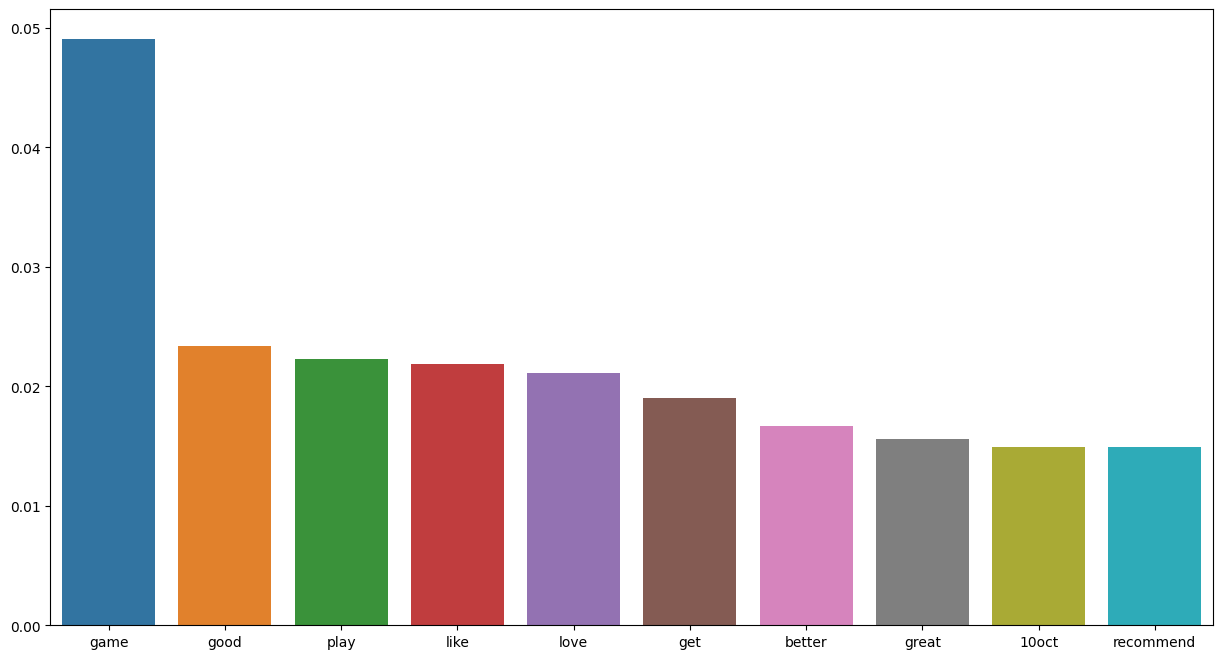

In [8]:
# Média de cada coluna e filtrando alguma quantidade de  palavras com maior média dos pesos em cada review
mean = tfidf_tabela.mean(axis=0)

def mean_top (numero):
    mean_top = pd.DataFrame(round(mean.nlargest(numero),4), columns=['mean']).T
    return sns.barplot(data = mean_top).figure.set_size_inches(15,8)

# modificar número
mean_top(10)


# K-means
Precisa-se chegar a um número ideal de clusters, plotar gráfico, analisar SSE.

In [9]:
# Clusters (K-means) - método não-supervisionado
k = 10
kmeans = KMeans(n_clusters=k, random_state=111)
kmeans.fit(tfidf_tabela)
labels = kmeans.labels_
dados_cod['etiquetas_cluster'] = labels


c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


# Naive Bayes Multinomial
Funciona bem para features com valor discreto, mas é um bom modelo para pesos produzidos pelo TF-IDF. Se a correlação enre os elementos for importante, o Naive-Bayes não é a melhor alternativa.

In [41]:
# Base treino (80%) e teste (20%)
y = dados_cod['avaliacao_new']

treino_x, teste_x, treino_y, teste_y = train_test_split(tfidf, y, test_size=0.2, random_state=111, stratify=y)

In [42]:
naive_bayes = MultinomialNB()
naive_bayes.fit(treino_x, treino_y)
predicts = naive_bayes.predict(teste_x)

acuracia = accuracy_score(teste_y, predicts)
print(acuracia)


relatorio = classification_report(teste_y, predicts)
print(relatorio)

0.9883227176220807


c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\JoãoPinheiro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
